In [1]:
# Cell 1: Installs and Imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import json
import os
import random
import numpy as np
from tqdm.notebook import tqdm
import torch.nn.functional as F
import math
import time # For timing epochs
from py_vncorenlp import VnCoreNLP


print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Device Name: NVIDIA GeForce RTX 4090


In [2]:
# Cell 2: Configuration Class (CFG)
# import torch
# import os

# ==============================================================================
# Configuration Class (CFG)
# ==============================================================================
class CFG:
    # --- Paths ---
    # /root/Tuning-CLIP/data/UIT-OpenViIC-dataset/images/00000000000.png
    # Base directory where your train.json, dev.json, test.json are located
    data_path = "./json_data//"
    image_path = "./data/UIT-OpenViIC-dataset/"

    # Output directory for saved models
    model_path = "./ViCLIP_uitopenviic"

    # --- Available Models ---
    text_models = {
        "PhoBERT-base": "vinai/phobert-base",
        "PhoBERT-large": "vinai/phobert-large",
        "ViT5-base": "VietAI/vit5-base",
        "ViT5-large": "VietAI/vit5-large"
    }
    image_models = {
        "ViT-S": "vit_small_patch16_224", "ViT-B": "vit_base_patch16_224",
        "ViT-L": "vit_large_patch16_224", "ViT-H": "vit_huge_patch16_224",
        "ResNet50": "resnet50"
    }

    # --- User Selections ---
    selected_text_model = "PhoBERT-base"
    selected_image_model = "ResNet50"

    # --- Model parameters based on selection (Properties) ---
    @property
    def model_name(self): return self.image_models[self.selected_image_model]
    @property
    def text_encoder_model(self): return self.text_models[self.selected_text_model]
    @property
    def text_tokenizer(self): return self.text_models[self.selected_text_model]

    @property
    def text_embedding(self): # Encoder output dim before projection
        model_key = self.text_models[self.selected_text_model]
        if "large" in model_key: return 1024
        elif "base" in model_key: return 768
        else: print(f"Warning: Unknown text embedding size for {model_key}, defaulting to 768."); return 768

    @property
    def image_embedding(self): # Encoder output dim before projection
        if self.selected_image_model == "ResNet50": return 2048
        elif self.selected_image_model == "ViT-S": return 384
        elif self.selected_image_model == "ViT-B": return 768
        elif self.selected_image_model == "ViT-L": return 1024
        elif self.selected_image_model == "ViT-H": return 1280
        else: print(f"Warning: Unknown image embedding size for {self.model_name}, defaulting to 768."); return 768
    
    # --- Fixed parameters ---
    projection_dim = 256 # Shared latent space dimension

    # --- Training parameters ---
    seed = 42
    batch_size = 64
    num_workers = 20  
    head_lr = 5e-4
    image_encoder_lr = 2e-4
    text_encoder_lr = 2e-5
    weight_decay = 5e-3
    patience = 7
    factor = 0.8
    epochs = 20
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Image/Text parameters ---
    size = 224 # Input image size
    max_length = 200 # Max text sequence length

    # --- Loss/Saving parameters ---
    temperature = 0.07
    save_best_only = True
    metric_to_track = "avg_acc"
    mode = "max" if metric_to_track != "loss" else "min"


# --- Instantiate Config and Create Output Dir ---
config = CFG()
os.makedirs(config.model_path, exist_ok=True)
print(f"Using device: {config.device}")
print(f"Model output path: {config.model_path}")
print(f"Image base path (for resolving paths in JSON): {os.path.abspath(config.image_path)}")

Using device: cuda
Model output path: ./ViCLIP_uitopenviic
Image base path (for resolving paths in JSON): /root/TuningModels/data/UIT-OpenViIC-dataset


In [3]:
# Cell 3: Seeding for Reproducibility

def set_seed(seed=config.seed):
    print(f"Setting seed: {seed}")
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU
        # These can slow down training, use cautiously if performance is critical
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

Setting seed: 42


In [4]:
# Cell 4: Metric Calculation Utilities

class AvgMeter:
    """Computes and stores the average and current value"""
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, count=1):
        # Ensure val is a scalar number before adding to sum
        if torch.is_tensor(val):
             val = val.item() # Convert tensor to Python number
        if isinstance(val, (int, float)):
            self.sum += val * count
            self.count += count
            self.avg = self.sum / self.count if self.count != 0 else 0
        # else:
            # Optionally print a warning if the value is not usable
            # print(f"Warning: Cannot update AvgMeter '{self.name}' with value type {type(val)}")


    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def compute_recall_at_k(similarity_matrix, k, dim):
    n = similarity_matrix.shape[1-dim]
    correct_count = 0
    top_k_indices = torch.topk(similarity_matrix, k, dim=dim).indices
    ground_truth = torch.arange(n, device=similarity_matrix.device)

    if dim == 0: # I2T
        for img_idx in range(n):
            if ground_truth[img_idx] in top_k_indices[:, img_idx]:
                correct_count += 1
    elif dim == 1: # T2I
        for txt_idx in range(n):
             if ground_truth[txt_idx] in top_k_indices[txt_idx, :]:
                correct_count += 1
    else: raise ValueError("dim must be 0 or 1")
    return correct_count / n if n > 0 else 0.0

def compute_metrics(image_embeddings, text_embeddings):
    sim_matrix = text_embeddings @ image_embeddings.T
    sim_matrix = sim_matrix.float() # Ensure float for calculations
    n = sim_matrix.shape[0]
    if n == 0:
        # Return default zero metrics for empty batch
        return {
            "i2t_acc": 0.0, "t2i_acc": 0.0, "avg_acc": 0.0,
            "avg_cosine_sim": 0.0,
            "i2t_recall": {"R@1": 0.0, "R@5": 0.0, "R@10": 0.0},
            "t2i_recall": {"R@1": 0.0, "R@5": 0.0, "R@10": 0.0}
        }

    ground_truth = torch.arange(n, device=sim_matrix.device)
    i2t_preds = torch.argmax(sim_matrix, dim=0)
    t2i_preds = torch.argmax(sim_matrix, dim=1)
    i2t_acc = (i2t_preds == ground_truth).float().mean().item()
    t2i_acc = (t2i_preds == ground_truth).float().mean().item()
    avg_acc = (i2t_acc + t2i_acc) / 2
    avg_cosine_sim = torch.diagonal(sim_matrix).mean().item()

    i2t_recall = {}
    t2i_recall = {}
    recall_k_values = [k for k in [1, 5, 10] if k <= n]
    for k in recall_k_values:
        i2t_recall[f"R@{k}"] = compute_recall_at_k(sim_matrix, k, dim=0)
        t2i_recall[f"R@{k}"] = compute_recall_at_k(sim_matrix, k, dim=1)

    # Ensure all keys R@1, R@5, R@10 exist even if k>n
    for k in [1, 5, 10]:
        k_str = f"R@{k}"
        if k_str not in i2t_recall: i2t_recall[k_str] = 0.0
        if k_str not in t2i_recall: t2i_recall[k_str] = 0.0

    metrics = {
        "i2t_acc": i2t_acc, "t2i_acc": t2i_acc, "avg_acc": avg_acc,
        "avg_cosine_sim": avg_cosine_sim,
        "i2t_recall": i2t_recall, "t2i_recall": t2i_recall
    }
    return metrics

print("Metric utilities defined.")

Metric utilities defined.


In [5]:
# Cell 5: Dataset Class Definition

class ImageCaptionDataset(Dataset):
    def __init__(self, json_path, image_base_path, tokenizer, transforms, max_length):
        super().__init__()
        print(f"Attempting to load data from: {os.path.abspath(json_path)}")
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                self.data = json.load(f)
        except FileNotFoundError:
            print(f"ERROR: JSON file not found at {json_path}")
            print(f"       Please ensure '{json_path}' exists relative to your notebook or provide the full path.")
            self.data = []
            # Optionally raise error: raise FileNotFoundError(f"JSON file not found at {json_path}")
        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from {json_path}")
            self.data = []
        except Exception as e:
            print(f"An unexpected error occurred loading {json_path}: {e}")
            self.data = []

        print(f"Found {len(self.data)} samples in {os.path.basename(json_path)}.")
        self.image_base_path = image_base_path
        self.tokenizer = tokenizer
        self.transforms = transforms
        self.max_length = max_length
        # Optional: Check if the image base path exists
        if not os.path.isdir(self.image_base_path):
             print(f"WARNING: Image base path does not exist: {os.path.abspath(self.image_base_path)}")
             print(f"         Ensure 'image_path' in CFG points to the correct directory relative to your notebook.")


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx >= len(self.data):
             raise IndexError("Index out of bounds")
        item = self.data[idx]
        relative_image_path = item.get('image_path', None) # Use .get for safety
        caption = item.get('caption', '') # Use .get for safety

        if relative_image_path is None:
            print(f"Warning: Missing 'image_path' for item at index {idx}. Returning dummy data.")
            image = torch.zeros((3, config.size, config.size))
        else:
            image_path = os.path.normpath(os.path.join(self.image_base_path, relative_image_path))
            # /root/Tuning-CLIP/data/UIT-OpenViIC-dataset/images/00000000000.png
            try:
                image = Image.open(image_path).convert('RGB')
                image = self.transforms(image)
            except FileNotFoundError:
                print(f"Warning: Img not found: {image_path}. Base: {self.image_base_path}, Rel: {relative_image_path}")
                image = torch.zeros((3, config.size, config.size))
            except Exception as e:
                print(f"Warning: Error loading image {image_path}: {e}")
                image = torch.zeros((3, config.size, config.size))

        # Process text with consistent dimensions
        text_inputs = self.tokenizer(
            caption, padding='max_length', truncation=True,
            max_length=self.max_length, return_tensors='pt'
        )
        
        # Always get first dimension (which should be batch dim of 1) and ensure 1D tensor
        input_ids = text_inputs['input_ids'][0]
        attention_mask = text_inputs['attention_mask'][0]
        
        # Verify tensors are 1D
        if input_ids.dim() > 1:
            # If somehow we get 2D tensor, flatten to 1D
            input_ids = input_ids.view(-1)
            
        if attention_mask.dim() > 1:
            attention_mask = attention_mask.view(-1)

        return {
            "image": image,
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }

print("ImageCaptionDataset class defined.")

ImageCaptionDataset class defined.


In [6]:
# Cell 6: Model Component Definitions (Encoders, CLIP Model, Loss)

# --- Image Encoder ---
class ImageEncoder(nn.Module):
    def __init__(self, config, pretrained=True):
        super().__init__()
        self.config = config
        print(f"Initializing Image Encoder: {config.selected_image_model}")
        if config.selected_image_model == "ResNet50":
            weights = models.ResNet50_Weights.DEFAULT if pretrained else None
            self.model = models.resnet50(weights=weights)
            self.input_features = config.image_embedding
            self.model.fc = nn.Identity()
            print(f"  Loaded ResNet50 from torchvision. Input features: {self.input_features}")
        # --- Add ViT logic here if needed ---
        # elif "ViT" in config.selected_image_model:
        #     try:
        #         import timm
        #     except ImportError:
        #         print("Please install timm library ('pip install timm') to use ViT models.")
        #         raise
        #     print(f"  Loading {config.model_name} using timm.")
        #     self.model = timm.create_model(config.model_name, pretrained=pretrained)
        #     self.input_features = config.image_embedding # Should match timm model output before head
        #     # Verify input_features matches actual output if possible, e.g., self.model.embed_dim
        #     # print(f"    ViT embed_dim: {self.model.embed_dim}") # Example check
        #     self.model.head = nn.Identity() # Remove classification head
        #     print(f"    Removed head. Input features to projection: {self.input_features}")
        # --- End ViT logic ---
        else:
            raise ValueError(f"Unsupported image model type in config: {config.selected_image_model}")

        self.projection = nn.Linear(self.input_features, self.config.projection_dim)
        print(f"  Added projection head: {self.input_features} -> {self.config.projection_dim}")


    def forward(self, x):
        features = self.model(x)
        # ViT models might output class token + patch tokens, check model architecture
        # If using ViT, might need features = features[:, 0] to get class token
        features = features.view(features.size(0), -1) # Flatten if needed
        projected_features = self.projection(features)
        projected_features = F.normalize(projected_features, p=2, dim=-1)
        return projected_features

# --- Text Encoder ---
class TextEncoder(nn.Module):
    def __init__(self, config, pretrained=True):
        super().__init__()
        self.config = config
        self.input_features = config.text_embedding # Dim before projection
        print(f"Initializing Text Encoder: {config.text_encoder_model}")
        print(f"  Expected input features: {self.input_features}")
        if pretrained:
            self.model = AutoModel.from_pretrained(config.text_encoder_model)
        else:
            model_config = AutoConfig.from_pretrained(config.text_encoder_model)
            self.model = AutoModel.from_config(model_config)

        # Check if actual model hidden size matches config
        actual_hidden_size = self.model.config.hidden_size
        if actual_hidden_size != self.input_features:
             print(f"WARNING: Configured text_embedding ({self.input_features}) does not match actual model hidden size ({actual_hidden_size}). Using actual size for projection.")
             self.input_features = actual_hidden_size # Use actual size

        self.projection = nn.Linear(self.input_features, self.config.projection_dim)
        print(f"  Added projection head: {self.input_features} -> {self.config.projection_dim}")


    def forward(self, input_ids, attention_mask):
        if input_ids.dim() == 1: input_ids = input_ids.unsqueeze(0)
        if attention_mask.dim() == 1: attention_mask = attention_mask.unsqueeze(0)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        # Using [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        projected_features = self.projection(cls_embedding)
        projected_features = F.normalize(projected_features, p=2, dim=-1)
        return projected_features

# --- CLIP Model ---
class CLIPViModel(nn.Module):
    def __init__(self, image_encoder, text_encoder, config):
        super().__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temperature = config.temperature

    def forward(self, image, input_ids, attention_mask):
        image_features = self.image_encoder(image)
        text_features = self.text_encoder(input_ids, attention_mask)
        logit_scale = 1 / self.temperature
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()
        return logits_per_image, logits_per_text, image_features, text_features

# --- Loss Function ---
def contrastive_loss(logits_per_image, logits_per_text):
    batch_size = logits_per_image.shape[0]
    if batch_size == 0: return torch.tensor(0.0, device=logits_per_image.device, requires_grad=True) # Handle empty batch
    labels = torch.arange(batch_size, device=logits_per_image.device)
    loss_img = F.cross_entropy(logits_per_image, labels)
    loss_txt = F.cross_entropy(logits_per_text, labels)
    total_loss = (loss_img + loss_txt) / 2.0
    return total_loss

print("Model components and loss function defined.")

Model components and loss function defined.


In [7]:
# Cell 7: Training and Validation Epoch Functions

def train_epoch(model, dataloader, optimizer, device, epoch_num):
    model.train()
    loss_meter = AvgMeter(f"Train Loss E{epoch_num}")
    # Using tqdm.notebook for progress bar
    progress_bar = tqdm(dataloader, desc=f"Training E{epoch_num}", leave=False, unit="batch")
    for batch in progress_bar:
        optimizer.zero_grad()
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_size = images.size(0)
        if batch_size == 0: continue # Skip empty batches

        logits_per_image, logits_per_text, _, _ = model(images, input_ids, attention_mask)
        loss = contrastive_loss(logits_per_image, logits_per_text)
        loss.backward()
        optimizer.step()
        loss_meter.update(loss.item(), batch_size)
        progress_bar.set_postfix(loss=f"{loss_meter.avg:.4f}")

    return loss_meter.avg

def validate_epoch(model, dataloader, device, epoch_num):
    model.eval()
    # Initialize meters
    loss_meter = AvgMeter(f"Val Loss E{epoch_num}")
    acc_meter = AvgMeter(f"Val Acc E{epoch_num}")
    cos_sim_meter = AvgMeter(f"Val CosSim E{epoch_num}")
    # Initialize all potential recall meters
    recall_meters = {
        "i2t_R@1": AvgMeter(f"Val I2T R@1 E{epoch_num}"), "i2t_R@5": AvgMeter(f"Val I2T R@5 E{epoch_num}"), "i2t_R@10": AvgMeter(f"Val I2T R@10 E{epoch_num}"),
        "t2i_R@1": AvgMeter(f"Val T2I R@1 E{epoch_num}"), "t2i_R@5": AvgMeter(f"Val T2I R@5 E{epoch_num}"), "t2i_R@10": AvgMeter(f"Val T2I R@10 E{epoch_num}"),
    }

    progress_bar = tqdm(dataloader, desc=f"Validation E{epoch_num}", leave=False, unit="batch")
    with torch.no_grad():
        for batch in progress_bar:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_size = images.size(0)
            if batch_size == 0: continue # Skip empty batches

            logits_per_image, logits_per_text, image_features, text_features = model(images, input_ids, attention_mask)
            loss = contrastive_loss(logits_per_image, logits_per_text)
            metrics = compute_metrics(image_features, text_features)

            # Update meters
            loss_meter.update(loss.item(), batch_size)
            acc_meter.update(metrics["avg_acc"], batch_size)
            cos_sim_meter.update(metrics["avg_cosine_sim"], batch_size)
            for k_val, meter in recall_meters.items():
                 recall_type, recall_key = k_val.split('_') # 'i2t'/'t2i', 'R@k'
                 if recall_key in metrics[f"{recall_type}_recall"]:
                    meter.update(metrics[f"{recall_type}_recall"][recall_key], batch_size)

            progress_bar.set_postfix(loss=f"{loss_meter.avg:.4f}", acc=f"{acc_meter.avg:.3f}")

    # Collect results
    validation_results = {"loss": loss_meter.avg, "avg_acc": acc_meter.avg, "avg_cosine_sim": cos_sim_meter.avg}
    for k_val, meter in recall_meters.items():
         validation_results[k_val.replace("_", " ")] = meter.avg # Format key nicely

    return validation_results

print("Training and Validation epoch functions defined.")

Training and Validation epoch functions defined.


In [8]:
# Cell 8: Setup - Tokenizer and Transforms

# 1. Load Tokenizer
print(f"Loading Tokenizer: {config.text_tokenizer}")
try:
    tokenizer = AutoTokenizer.from_pretrained(config.text_tokenizer)
    print("Tokenizer loaded successfully.")
except Exception as e:
    print(f"ERROR loading tokenizer '{config.text_tokenizer}': {e}")
    print("Please ensure the model name is correct and you have internet access or the model is cached.")
    # Optionally raise the error to stop execution
    # raise e

# 2. Define Image Transforms
image_transforms = transforms.Compose([
    transforms.Resize(config.size),
    transforms.CenterCrop(config.size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet stats
])
print("Image transforms defined.")

Loading Tokenizer: vinai/phobert-base


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Tokenizer loaded successfully.
Image transforms defined.


In [9]:
# Cell 9: Setup - Datasets and DataLoaders

print("\nCreating datasets...")
# Construct JSON paths using config.data_path
# /Users/quanghuypham/Desktop/CP_Glimpse/Tuning-CLIP/data/UIT-OpenViIC-dataset/test.json
train_json = f"{os.path.abspath(config.data_path)}/train.json"
dev_json = f"{os.path.abspath(config.data_path)}/dev.json"
test_json = f"{os.path.abspath(config.data_path)}/test.json"

# Make sure tokenizer is loaded before creating datasets
if 'tokenizer' not in globals():
     print("ERROR: Tokenizer not loaded. Please run the previous cell.")
else:
    train_dataset = ImageCaptionDataset(
        json_path=train_json, image_base_path=config.image_path,
        tokenizer=tokenizer, transforms=image_transforms, max_length=config.max_length
    )
    dev_dataset = ImageCaptionDataset(
        json_path=dev_json, image_base_path=config.image_path,
        tokenizer=tokenizer, transforms=image_transforms, max_length=config.max_length
    )

    # Basic checks after loading
    if not train_dataset.data:
        print("\nERROR: Failed to load training data. Check 'train_json' path and format.")
        # Optionally raise an error: raise ValueError("Training data failed to load")
    if not dev_dataset.data:
         print("\nWARNING: Failed to load validation data. Validation steps will be skipped.")

    print("\nCreating dataloaders...")
    num_workers = min(config.num_workers, os.cpu_count() if os.cpu_count() else 1)
    print(f"Using {num_workers} workers for DataLoaders.")

    train_loader = None
    if train_dataset.data:
        train_loader = DataLoader(
            train_dataset, batch_size=config.batch_size, shuffle=True,
            num_workers=num_workers, pin_memory=True if config.device == torch.device("cuda") else False,
            drop_last=False # Keep last incomplete batch for training
        )
        print(f"Train loader created with {len(train_loader)} batches.")

    dev_loader = None
    if dev_dataset.data:
        dev_loader = DataLoader(
            dev_dataset, batch_size=config.batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=True if config.device == torch.device("cuda") else False,
            drop_last=False # Keep last incomplete batch for validation
        )
        print(f"Validation loader created with {len(dev_loader)} batches.")

    if not train_loader:
         print("\nERROR: Train loader could not be created. Cannot proceed.")
         # raise ValueError("Train loader creation failed")


Creating datasets...
Attempting to load data from: /root/TuningModels/json_data/train.json
Found 41236 samples in train.json.
Attempting to load data from: /root/TuningModels/json_data/dev.json
Found 10002 samples in dev.json.

Creating dataloaders...
Using 20 workers for DataLoaders.
Train loader created with 645 batches.
Validation loader created with 157 batches.


In [10]:
# Cell 10: Setup - Model, Optimizer, Scheduler

print("\nInitializing model components...")
try:
    image_encoder = ImageEncoder(config).to(config.device)
    text_encoder = TextEncoder(config).to(config.device)
    model = CLIPViModel(image_encoder, text_encoder, config).to(config.device)
    print(f"\nCLIPViModel initialized successfully on {config.device}.")
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {num_params / 1e6:.2f} M")

except Exception as e:
    print(f"ERROR initializing models: {e}")
    print("Check model names in CFG, internet connection, and available memory.")
    # raise e # Optionally stop execution

# --- Optimizer Setup ---
if 'model' in globals() : # Check if model was created
    print("\nSetting up optimizer...")
    image_encoder_params = list(model.image_encoder.model.parameters())
    image_head_params = list(model.image_encoder.projection.parameters())
    text_encoder_params = list(model.text_encoder.model.parameters())
    text_head_params = list(model.text_encoder.projection.parameters())

    print(f"  Param counts: ImgBase={len(image_encoder_params)}, ImgHead={len(image_head_params)}, TxtBase={len(text_encoder_params)}, TxtHead={len(text_head_params)}")

    optimizer_grouped_parameters = [
        {"params": [p for p in image_encoder_params if p.requires_grad], "lr": config.image_encoder_lr, "weight_decay": config.weight_decay},
        {"params": [p for p in image_head_params if p.requires_grad], "lr": config.head_lr, "weight_decay": config.weight_decay},
        {"params": [p for p in text_encoder_params if p.requires_grad], "lr": config.text_encoder_lr, "weight_decay": config.weight_decay},
        {"params": [p for p in text_head_params if p.requires_grad], "lr": config.head_lr, "weight_decay": config.weight_decay},
    ]

    # Filter out groups with no parameters (can happen if parts are frozen)
    optimizer_grouped_parameters = [g for g in optimizer_grouped_parameters if g['params']]

    if not optimizer_grouped_parameters:
         print("ERROR: No parameters found for the optimizer. Check model structure and requires_grad flags.")
         # raise ValueError("Optimizer has no parameters")
    else:
        optimizer = optim.AdamW(optimizer_grouped_parameters)
        print(f"Optimizer AdamW initialized.")

        # --- LR Scheduler Setup ---
        lr_scheduler = ReduceLROnPlateau(
            optimizer, mode=config.mode, # Use mode from config ('min' for loss, 'max' for acc/recall)
            factor=config.factor, patience=config.patience
        )
        print(f"LR Scheduler ReduceLROnPlateau initialized (mode='{config.mode}', factor={config.factor}, patience={config.patience})")
        
        # --- Early Stopping Setup ---
        early_stopping_patience = getattr(config, 'early_stopping_patience', 5) 
        early_stopping_min_delta = getattr(config, 'early_stopping_min_delta', 0.001)
        early_stopping_counter = 0
        print(f"Early stopping initialized (patience={early_stopping_patience}, min_delta={early_stopping_min_delta})")

else:
    print("ERROR: Model not initialized. Skipping optimizer/scheduler setup.")


Initializing model components...
Initializing Image Encoder: ResNet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.9MB/s]


  Loaded ResNet50 from torchvision. Input features: 2048
  Added projection head: 2048 -> 256
Initializing Text Encoder: vinai/phobert-base
  Expected input features: 768


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

  Added projection head: 768 -> 256

CLIPViModel initialized successfully on cuda.
Trainable parameters: 159.23 M

Setting up optimizer...
  Param counts: ImgBase=159, ImgHead=2, TxtBase=199, TxtHead=2
Optimizer AdamW initialized.
LR Scheduler ReduceLROnPlateau initialized (mode='max', factor=0.8, patience=7)
Early stopping initialized (patience=5, min_delta=0.001)


In [11]:
# Cell 11: Training Loop

if 'model' in globals() and 'train_loader' in globals() and 'optimizer' in globals(): # Check prerequisites
    print(f"\nStarting training for {config.epochs} epochs...")
    print(f"Tracking metric: '{config.metric_to_track}' (mode: {config.mode})")

    best_val_metric = -float('inf') if config.mode == "max" else float('inf')
    history = {'train_loss': [], 'validation_results': []}
    start_train_time = time.time()

    for epoch in range(config.epochs):
        epoch_start_time = time.time()
        print(f"\n--- Epoch {epoch+1}/{config.epochs} ---")
        # --- Training ---
        train_loss = train_epoch(model, train_loader, optimizer, config.device, epoch+1)
        history['train_loss'].append(train_loss)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}")

        # --- Validation ---
        val_results = {"loss": float('inf'), "avg_acc": 0.0} # Default if no validation
        if dev_loader:
            val_results = validate_epoch(model, dev_loader, config.device, epoch+1)
            history['validation_results'].append(val_results)
            # Print validation metrics
            print("  Validation Metrics:")
            metric_log_str = "  "
            for name, value in val_results.items():
                metric_log_str += f"{name}: {value:.4f} | "
            print(metric_log_str.strip(" | "))

            # Step the LR scheduler based on the tracked metric
            current_val_metric_for_scheduler = val_results.get(config.metric_to_track, None)
            if current_val_metric_for_scheduler is not None:
                 lr_scheduler.step(current_val_metric_for_scheduler)
                 current_lrs = [group['lr'] for group in optimizer.param_groups]
                 # Simplified LR print: print first + last group LR assuming Head LRs are same
                 print(f"  Current LRs: ImgEnc={current_lrs[0]:.2e}, Head={current_lrs[1]:.2e}, TxtEnc={current_lrs[2]:.2e}")
            else:
                 print(f"  Warning: Metric '{config.metric_to_track}' not found in validation results. Scheduler not stepped.")

        else:
             print("  Validation skipped.")
             history['validation_results'].append(None) # Append None if no validation

        # --- Save Checkpoint ---
        current_val_metric = val_results.get(config.metric_to_track, -float('inf') if config.mode == "max" else float('inf'))

        is_best = False
        if dev_loader: # Only compare if validation was done
            if config.mode == "max" and current_val_metric > best_val_metric:
                is_best = True
                best_val_metric = current_val_metric
            elif config.mode == "min" and current_val_metric < best_val_metric:
                is_best = True
                best_val_metric = current_val_metric

        # Prepare save dictionary
        save_dict = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'train_loss': train_loss,
            'validation_results': val_results,
            'best_val_metric': best_val_metric, # Store the best metric value seen so far
            'metric_tracked': config.metric_to_track, # Store which metric was tracked
        }

        # Save logic
        if config.save_best_only and dev_loader:
            if is_best:
                best_checkpoint_path = os.path.join(config.model_path, "clip_vi_best.pt")
                torch.save(save_dict, best_checkpoint_path)
                print(f"  Saved Best Model (Epoch {epoch+1}, {config.metric_to_track}={current_val_metric:.4f}) to {best_checkpoint_path}")
        else: # Save every epoch if not save_best_only
            epoch_checkpoint_path = os.path.join(config.model_path, f"clip_vi_epoch_{epoch+1}.pt")
            torch.save(save_dict, epoch_checkpoint_path)
            print(f"  Saved Epoch {epoch+1} Checkpoint to {epoch_checkpoint_path}")
            if is_best and dev_loader: # Also save a copy as best if it's the best so far
                 best_checkpoint_path = os.path.join(config.model_path, "clip_vi_best.pt")
                 torch.save(save_dict, best_checkpoint_path)
                 print(f"  (Also saved as best model)")


        epoch_end_time = time.time()
        print(f"--- Epoch {epoch+1} Time: {epoch_end_time - epoch_start_time:.2f} seconds ---")


    # --- End of Training ---
    end_train_time = time.time()
    total_train_time = end_train_time - start_train_time
    print(f"\n=============== Training Finished ===============")
    print(f"Total Training Time: {total_train_time:.2f} seconds ({total_train_time/60:.2f} minutes)")
    final_model_path = os.path.join(config.model_path, 'clip_vi_final_epoch.pt')
    torch.save(save_dict, final_model_path) # Save the final epoch state regardless
    print(f"Final epoch model state saved to {final_model_path}")
    if config.save_best_only and dev_loader and os.path.exists(os.path.join(config.model_path, "clip_vi_best.pt")):
        print(f"Best model based on '{config.metric_to_track}' ({best_val_metric:.4f}) saved to: {os.path.join(config.model_path, 'clip_vi_best.pt')}")
    print(f"=================================================")

else:
    print("ERROR: Prerequisites for training (model, dataloader, optimizer) not met. Training loop skipped.")


Starting training for 20 epochs...
Tracking metric: 'avg_acc' (mode: max)

--- Epoch 1/20 ---


Training E1:   0%|          | 0/645 [00:00<?, ?batch/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1: Train Loss = 1.6457


Validation E1:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.3111 | avg_acc: 0.5988 | avg_cosine_sim: 0.5627 | i2t R@1: 0.6006 | i2t R@5: 0.9083 | i2t R@10: 0.9678 | t2i R@1: 0.5970 | t2i R@5: 0.9068 | t2i R@10: 0.9643
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
  Saved Best Model (Epoch 1, avg_acc=0.5988) to ./ViCLIP_uitopenviic/clip_vi_best.pt
--- Epoch 1 Time: 217.62 seconds ---

--- Epoch 2/20 ---


Training E2:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2: Train Loss = 0.8963


Validation E2:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.2079 | avg_acc: 0.6336 | avg_cosine_sim: 0.5621 | i2t R@1: 0.6310 | i2t R@5: 0.9241 | i2t R@10: 0.9719 | t2i R@1: 0.6363 | t2i R@5: 0.9231 | t2i R@10: 0.9699
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
  Saved Best Model (Epoch 2, avg_acc=0.6336) to ./ViCLIP_uitopenviic/clip_vi_best.pt
--- Epoch 2 Time: 214.55 seconds ---

--- Epoch 3/20 ---


Training E3:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3: Train Loss = 0.6398


Validation E3:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1814 | avg_acc: 0.6433 | avg_cosine_sim: 0.5462 | i2t R@1: 0.6427 | i2t R@5: 0.9244 | i2t R@10: 0.9713 | t2i R@1: 0.6440 | t2i R@5: 0.9241 | t2i R@10: 0.9702
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
  Saved Best Model (Epoch 3, avg_acc=0.6433) to ./ViCLIP_uitopenviic/clip_vi_best.pt
--- Epoch 3 Time: 214.68 seconds ---

--- Epoch 4/20 ---


Training E4:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4: Train Loss = 0.4914


Validation E4:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1658 | avg_acc: 0.6510 | avg_cosine_sim: 0.5397 | i2t R@1: 0.6498 | i2t R@5: 0.9228 | i2t R@10: 0.9706 | t2i R@1: 0.6522 | t2i R@5: 0.9241 | t2i R@10: 0.9695
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
  Saved Best Model (Epoch 4, avg_acc=0.6510) to ./ViCLIP_uitopenviic/clip_vi_best.pt
--- Epoch 4 Time: 214.80 seconds ---

--- Epoch 5/20 ---


Training E5:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

Epoch 5: Train Loss = 0.4040


Validation E5:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1373 | avg_acc: 0.6598 | avg_cosine_sim: 0.5428 | i2t R@1: 0.6571 | i2t R@5: 0.9254 | i2t R@10: 0.9729 | t2i R@1: 0.6625 | t2i R@5: 0.9272 | t2i R@10: 0.9721
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
  Saved Best Model (Epoch 5, avg_acc=0.6598) to ./ViCLIP_uitopenviic/clip_vi_best.pt
--- Epoch 5 Time: 214.98 seconds ---

--- Epoch 6/20 ---


Training E6:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6: Train Loss = 0.3357


Validation E6:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1485 | avg_acc: 0.6589 | avg_cosine_sim: 0.5316 | i2t R@1: 0.6549 | i2t R@5: 0.9233 | i2t R@10: 0.9713 | t2i R@1: 0.6630 | t2i R@5: 0.9259 | t2i R@10: 0.9692
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 6 Time: 213.20 seconds ---

--- Epoch 7/20 ---


Training E7:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

Epoch 7: Train Loss = 0.2928


Validation E7:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1297 | avg_acc: 0.6635 | avg_cosine_sim: 0.5277 | i2t R@1: 0.6629 | i2t R@5: 0.9265 | i2t R@10: 0.9732 | t2i R@1: 0.6642 | t2i R@5: 0.9267 | t2i R@10: 0.9699
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
  Saved Best Model (Epoch 7, avg_acc=0.6635) to ./ViCLIP_uitopenviic/clip_vi_best.pt
--- Epoch 7 Time: 214.28 seconds ---

--- Epoch 8/20 ---


Training E8:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8: Train Loss = 0.2546


Validation E8:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1603 | avg_acc: 0.6560 | avg_cosine_sim: 0.5175 | i2t R@1: 0.6533 | i2t R@5: 0.9219 | i2t R@10: 0.9705 | t2i R@1: 0.6588 | t2i R@5: 0.9217 | t2i R@10: 0.9668
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 8 Time: 213.67 seconds ---

--- Epoch 9/20 ---


Training E9:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9: Train Loss = 0.2290


Validation E9:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1613 | avg_acc: 0.6593 | avg_cosine_sim: 0.5186 | i2t R@1: 0.6571 | i2t R@5: 0.9212 | i2t R@10: 0.9703 | t2i R@1: 0.6615 | t2i R@5: 0.9237 | t2i R@10: 0.9683
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 9 Time: 213.40 seconds ---

--- Epoch 10/20 ---


Training E10:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10: Train Loss = 0.2054


Validation E10:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1365 | avg_acc: 0.6639 | avg_cosine_sim: 0.5215 | i2t R@1: 0.6653 | i2t R@5: 0.9235 | i2t R@10: 0.9704 | t2i R@1: 0.6626 | t2i R@5: 0.9251 | t2i R@10: 0.9693
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
  Saved Best Model (Epoch 10, avg_acc=0.6639) to ./ViCLIP_uitopenviic/clip_vi_best.pt
--- Epoch 10 Time: 214.79 seconds ---

--- Epoch 11/20 ---


Training E11:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 11: Train Loss = 0.1854


Validation E11:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1621 | avg_acc: 0.6585 | avg_cosine_sim: 0.5167 | i2t R@1: 0.6551 | i2t R@5: 0.9221 | i2t R@10: 0.9686 | t2i R@1: 0.6620 | t2i R@5: 0.9196 | t2i R@10: 0.9674
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 11 Time: 213.66 seconds ---

--- Epoch 12/20 ---


Training E12:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 12: Train Loss = 0.1680


Validation E12:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1550 | avg_acc: 0.6609 | avg_cosine_sim: 0.5159 | i2t R@1: 0.6588 | i2t R@5: 0.9233 | i2t R@10: 0.9672 | t2i R@1: 0.6630 | t2i R@5: 0.9240 | t2i R@10: 0.9677
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 12 Time: 213.23 seconds ---

--- Epoch 13/20 ---


Training E13:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 13: Train Loss = 0.1568


Validation E13:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1658 | avg_acc: 0.6572 | avg_cosine_sim: 0.5133 | i2t R@1: 0.6552 | i2t R@5: 0.9218 | i2t R@10: 0.9676 | t2i R@1: 0.6592 | t2i R@5: 0.9195 | t2i R@10: 0.9654
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 13 Time: 212.91 seconds ---

--- Epoch 14/20 ---


Training E14:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 14: Train Loss = 0.1445


Validation E14:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1678 | avg_acc: 0.6630 | avg_cosine_sim: 0.5110 | i2t R@1: 0.6613 | i2t R@5: 0.9180 | i2t R@10: 0.9643 | t2i R@1: 0.6648 | t2i R@5: 0.9175 | t2i R@10: 0.9633
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 14 Time: 212.99 seconds ---

--- Epoch 15/20 ---


Training E15:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 15: Train Loss = 0.1314


Validation E15:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1633 | avg_acc: 0.6590 | avg_cosine_sim: 0.5086 | i2t R@1: 0.6562 | i2t R@5: 0.9196 | i2t R@10: 0.9667 | t2i R@1: 0.6618 | t2i R@5: 0.9207 | t2i R@10: 0.9649
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 15 Time: 213.27 seconds ---

--- Epoch 16/20 ---


Training E16:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

Epoch 16: Train Loss = 0.1229


Validation E16:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1680 | avg_acc: 0.6618 | avg_cosine_sim: 0.5045 | i2t R@1: 0.6618 | i2t R@5: 0.9157 | i2t R@10: 0.9631 | t2i R@1: 0.6618 | t2i R@5: 0.9183 | t2i R@10: 0.9626
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 16 Time: 213.54 seconds ---

--- Epoch 17/20 ---


Training E17:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 17: Train Loss = 0.1173


Validation E17:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1712 | avg_acc: 0.6588 | avg_cosine_sim: 0.5047 | i2t R@1: 0.6597 | i2t R@5: 0.9191 | i2t R@10: 0.9656 | t2i R@1: 0.6580 | t2i R@5: 0.9192 | t2i R@10: 0.9644
  Current LRs: ImgEnc=2.00e-04, Head=5.00e-04, TxtEnc=2.00e-05
--- Epoch 17 Time: 212.84 seconds ---

--- Epoch 18/20 ---


Training E18:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 18: Train Loss = 0.1074


Validation E18:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1764 | avg_acc: 0.6579 | avg_cosine_sim: 0.5003 | i2t R@1: 0.6577 | i2t R@5: 0.9169 | i2t R@10: 0.9624 | t2i R@1: 0.6582 | t2i R@5: 0.9169 | t2i R@10: 0.9631
  Current LRs: ImgEnc=1.60e-04, Head=4.00e-04, TxtEnc=1.60e-05
--- Epoch 18 Time: 212.68 seconds ---

--- Epoch 19/20 ---


Training E19:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 19: Train Loss = 0.0882


Validation E19:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1739 | avg_acc: 0.6607 | avg_cosine_sim: 0.5000 | i2t R@1: 0.6606 | i2t R@5: 0.9135 | i2t R@10: 0.9616 | t2i R@1: 0.6609 | t2i R@5: 0.9152 | t2i R@10: 0.9606
  Current LRs: ImgEnc=1.60e-04, Head=4.00e-04, TxtEnc=1.60e-05
--- Epoch 19 Time: 213.95 seconds ---

--- Epoch 20/20 ---


Training E20:   0%|          | 0/645 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 20: Train Loss = 0.0771


Validation E20:   0%|          | 0/157 [00:00<?, ?batch/s]

/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/TuningModels/.venv/lib/python3.10/site-packa

  Validation Metrics:
loss: 1.1825 | avg_acc: 0.6588 | avg_cosine_sim: 0.4982 | i2t R@1: 0.6565 | i2t R@5: 0.9127 | i2t R@10: 0.9611 | t2i R@1: 0.6611 | t2i R@5: 0.9151 | t2i R@10: 0.9619
  Current LRs: ImgEnc=1.60e-04, Head=4.00e-04, TxtEnc=1.60e-05
--- Epoch 20 Time: 213.29 seconds ---

=============== Training Finished ===============
Total Training Time: 4278.31 seconds (71.31 minutes)
Final epoch model state saved to ./ViCLIP_uitopenviic/clip_vi_final_epoch.pt
Best model based on 'avg_acc' (0.6639) saved to: ./ViCLIP_uitopenviic/clip_vi_best.pt


In [12]:
# Cell 12: Final Evaluation on Test Set

print("\n=============== Starting Test Set Evaluation ===============")

test_json_path = os.path.join(config.data_path, "test.json")

if os.path.exists(test_json_path) and 'tokenizer' in globals():
    print(f"Loading test data from: {test_json_path}")
    test_dataset = ImageCaptionDataset(
        json_path=test_json_path, image_base_path=config.image_path,
        tokenizer=tokenizer, transforms=image_transforms, max_length=config.max_length
    )

    if test_dataset.data:
        num_workers = min(config.num_workers, os.cpu_count() if os.cpu_count() else 1)
        test_loader = DataLoader(
            test_dataset, batch_size=config.batch_size, shuffle=False,
            num_workers=num_workers, pin_memory=True if config.device == torch.device("cuda") else False,
            drop_last=False
        )
        print(f"Test loader created with {len(test_loader)} batches.")

        # --- Load Model for Testing ---
        # Create a fresh model instance
        try:
            test_image_encoder = ImageEncoder(config).to(config.device)
            test_text_encoder = TextEncoder(config).to(config.device)
            model_to_test = CLIPViModel(test_image_encoder, test_text_encoder, config).to(config.device)
            print("Model structure for testing created.")
        except Exception as e:
            print(f"ERROR creating model structure for testing: {e}")
            model_to_test = None # Prevent loading if structure fails

        if model_to_test:
            # Determine which model weights to load (best or final)
            best_model_path = os.path.join(config.model_path, "clip_vi_best.pt")
            final_model_path = os.path.join(config.model_path, "clip_vi_final_epoch.pt") # Use final epoch saved name

            load_path = None
            if os.path.exists(best_model_path):
                load_path = best_model_path
                print(f"Attempting to load best model weights from: {load_path}")
            elif os.path.exists(final_model_path):
                load_path = final_model_path
                print(f"Best model not found. Attempting to load final epoch weights from: {load_path}")
            else:
                print("WARNING: No saved model checkpoints ('best' or 'final') found in output directory.")
                print("         Evaluation will not be performed.")

            if load_path:
                try:
                    checkpoint = torch.load(load_path, map_location=config.device)
                    state_dict = checkpoint['model_state_dict']
                    # Handle potential 'module.' prefix if saved with DataParallel or DDP
                    if next(iter(state_dict)).startswith('module.'):
                        print("Detected 'module.' prefix, removing for loading.")
                        from collections import OrderedDict
                        new_state_dict = OrderedDict((k[7:], v) for k, v in state_dict.items())
                        model_to_test.load_state_dict(new_state_dict)
                    else:
                        model_to_test.load_state_dict(state_dict)
                    print(f"Model weights loaded successfully from {load_path}")

                    # --- Run Evaluation ---
                    print("\nRunning evaluation on test set...")
                    test_results = validate_epoch(model_to_test, test_loader, config.device, epoch_num="Test") # Use validate func

                    print("\n--- Test Set Results ---")
                    metric_log_str = ""
                    for name, value in test_results.items():
                        metric_log_str += f"  {name}: {value:.4f}\n"
                    print(metric_log_str.strip())
                    print("------------------------")

                except Exception as e:
                    print(f"\nERROR loading model weights or running evaluation from {load_path}: {e}")
                    import traceback
                    traceback.print_exc() # Print detailed traceback
            # --- End Model Loading/Eval ---
        # --- End Model Structure Check ---
    else:
         print("Could not load test data. Skipping test evaluation.")
else:
    if not os.path.exists(test_json_path):
         print(f"\nTest JSON path not found ({test_json_path}). Skipping test evaluation.")
    if 'tokenizer' not in globals():
         print("\nTokenizer not available. Skipping test evaluation.")

print("\n================= Evaluation Finished =================")


=============== Starting Test Set Evaluation ===============
Loading test data from: ./json_data//test.json
Attempting to load data from: /root/TuningModels/json_data/test.json
Found 10001 samples in test.json.
Test loader created with 157 batches.
Initializing Image Encoder: ResNet50


  Loaded ResNet50 from torchvision. Input features: 2048
  Added projection head: 2048 -> 256
Initializing Text Encoder: vinai/phobert-base
  Expected input features: 768
  Added projection head: 768 -> 256
Model structure for testing created.
Attempting to load best model weights from: ./ViCLIP_uitopenviic/clip_vi_best.pt
Model weights loaded successfully from ./ViCLIP_uitopenviic/clip_vi_best.pt

Running evaluation on test set...


Validation ETest:   0%|          | 0/157 [00:00<?, ?batch/s]


--- Test Set Results ---
loss: 1.2210
  avg_acc: 0.6497
  avg_cosine_sim: 0.5157
  i2t R@1: 0.6499
  i2t R@5: 0.9091
  i2t R@10: 0.9583
  t2i R@1: 0.6494
  t2i R@5: 0.9127
  t2i R@10: 0.9583
------------------------

================= Evaluation Finished =================


Plot directory created at: /root/TuningModels/train_plot


/tmp/ipykernel_2589/4958526.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Saved loss plot to: train_plot/training_loss.png
Saved accuracy plot to: train_plot/training_accuracy.png
Saved i2t_recall plot to: train_plot/training_i2t_recall.png
Saved t2i_recall plot to: train_plot/training_t2i_recall.png
Saved combined plot to: train_plot/training_metrics_combined.png


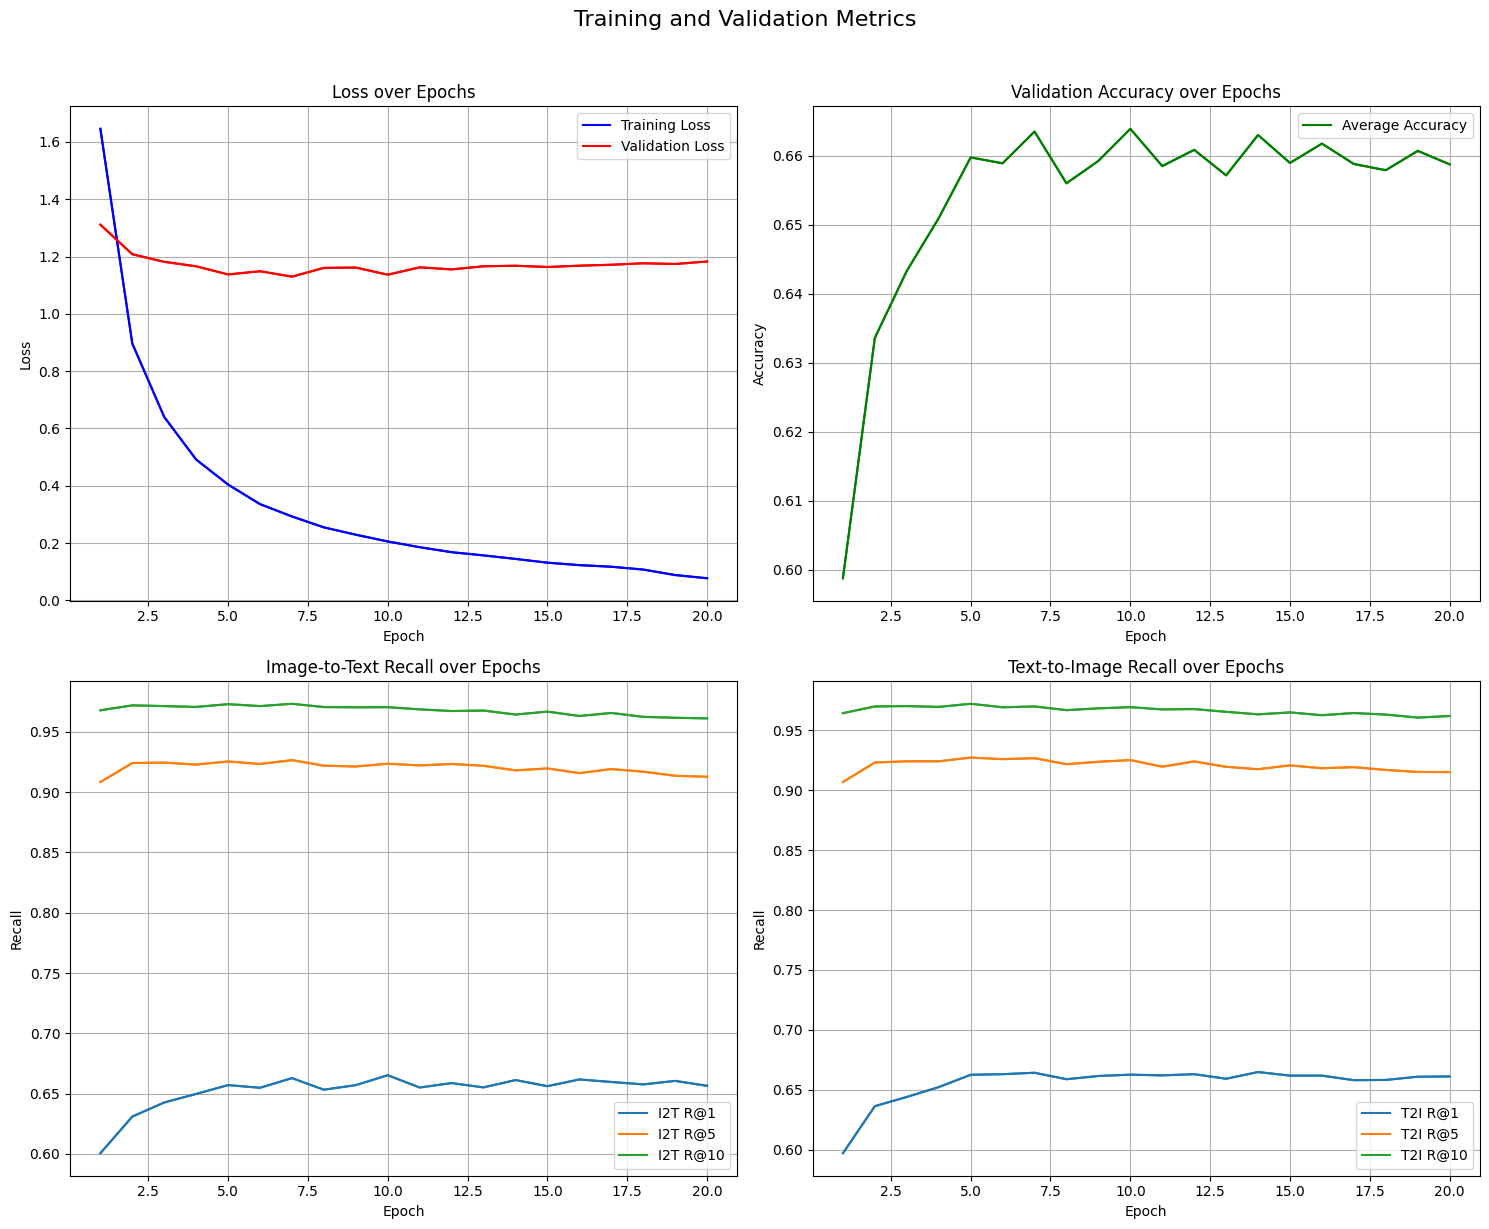

In [13]:
# Cell 13: Training Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Create train_plot directory if it doesn't exist
plot_dir = "train_plot/ViBLIP_uitopenviic"
os.makedirs(plot_dir, exist_ok=True)
print(f"Plot directory created at: {os.path.abspath(plot_dir)}")

def save_subplot_as_figure(subplot, save_path):
    """Helper function to save a subplot as a separate figure"""
    fig = plt.figure(figsize=(8, 6))
    # Copy the subplot content to the new figure
    ax = fig.add_subplot(111)
    ax.plot = subplot.plot
    ax.set_title(subplot.get_title())
    ax.set_xlabel(subplot.get_xlabel())
    ax.set_ylabel(subplot.get_ylabel())
    ax.grid(True)
    
    # Copy the lines and their labels
    lines = subplot.get_lines()
    labels = [line.get_label() for line in lines]
    for line in lines:
        ax.plot(line.get_xdata(), line.get_ydata(), 
                color=line.get_color(), 
                label=line.get_label(),
                linestyle=line.get_linestyle())
    
    if labels:
        ax.legend()
    
    plt.tight_layout()
    fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close(fig)

def plot_training_metrics(history):
    if not history['train_loss'] or not history['validation_results']:
        print("No training history available to plot.")
        return
        
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Training and Validation Metrics', fontsize=16, y=1.02)
    
    # Plot Training Loss
    epochs = range(1, len(history['train_loss']) + 1)
    val_loss = [res['loss'] for res in history['validation_results'] if res]
    
    axes[0,0].plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    if val_loss:
        axes[0,0].plot(epochs, val_loss, 'r-', label='Validation Loss')
    axes[0,0].set_title('Loss over Epochs')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Plot Accuracy
    if history['validation_results'] and 'avg_acc' in history['validation_results'][0]:
        val_acc = [res['avg_acc'] for res in history['validation_results'] if res]
        axes[0,1].plot(epochs, val_acc, 'g-', label='Average Accuracy')
        axes[0,1].set_title('Validation Accuracy over Epochs')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].legend()
        axes[0,1].grid(True)
    
    # Plot Recall Metrics
    if history['validation_results'] and 'i2t R@1' in history['validation_results'][0]:
        i2t_recall = {
            'R@1': [res['i2t R@1'] for res in history['validation_results'] if res],
            'R@5': [res['i2t R@5'] for res in history['validation_results'] if res],
            'R@10': [res['i2t R@10'] for res in history['validation_results'] if res]
        }
        
        for k, values in i2t_recall.items():
            axes[1,0].plot(epochs, values, label=f'I2T {k}')
        axes[1,0].set_title('Image-to-Text Recall over Epochs')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Recall')
        axes[1,0].legend()
        axes[1,0].grid(True)
        
        t2i_recall = {
            'R@1': [res['t2i R@1'] for res in history['validation_results'] if res],
            'R@5': [res['t2i R@5'] for res in history['validation_results'] if res],
            'R@10': [res['t2i R@10'] for res in history['validation_results'] if res]
        }
        
        for k, values in t2i_recall.items():
            axes[1,1].plot(epochs, values, label=f'T2I {k}')
        axes[1,1].set_title('Text-to-Image Recall over Epochs')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Recall')
        axes[1,1].legend()
        axes[1,1].grid(True)
    
    plt.tight_layout()
    
    # Save individual plots
    plot_names = ['loss', 'accuracy', 'i2t_recall', 't2i_recall']
    for idx, name in enumerate(plot_names):
        i, j = divmod(idx, 2)
        save_path = os.path.join(plot_dir, f'training_{name}.png')
        save_subplot_as_figure(axes[i,j], save_path)
        print(f"Saved {name} plot to: {save_path}")
    
    # Save combined plot
    combined_save_path = os.path.join(plot_dir, 'training_metrics_combined.png')
    fig.savefig(combined_save_path, bbox_inches='tight', dpi=300)
    print(f"Saved combined plot to: {combined_save_path}")
    
    # Display the plot
    plt.show()
    plt.close()

# Plot if history exists
if 'history' in globals():
    plot_training_metrics(history)
else:
    print("No training history found. Run training first.")